In [11]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib import rc
from matplotlib.ticker import AutoMinorLocator

rc('font',**{'family':'serif','serif':['Times New Roman'],'weight': 'bold'})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])

def default_axis(figsize = (6,4.5), 
               xlabel: str = None,
               ylabel: str = None,
               labelsize: int = 10,
               fontsize: int = 11,
               ax: plt.Axes = None,
               n_minor_ticks: int = 5):

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = None
    
    ax.set_xlabel(xlabel,fontsize = 10)
    ax.set_ylabel(ylabel,fontsize  = fontsize)
    ax.tick_params('both',labelsize = labelsize,direction = 'in',which = 'both')

    ax.xaxis.set_minor_locator(AutoMinorLocator(n_minor_ticks))
    ax.yaxis.set_minor_locator(AutoMinorLocator(n_minor_ticks))
    
    return fig,ax

### Application Description

We want to estimate the reduction in material Vickers hardness due to _recrystilization_, a type of solid material phase change, for a tungsten alloy (K doped 3% Rhenium W alloy). The kinetics of recrystilization are a function of both time and temperature. Unfortunately, the only high quality recrystillizatoin experimental data that covers a broad swathe of temperatures is for pure W [1]. We believe after an initial assessment of the data that:

1. The ultimate reduction in the hardness (fully recrystallized material) is independant of the recrystillization temperature.
2. The reduction is relatively constant across material pre-processing

The later assumption is mostly for convinience, made so we can create a single point estimate (and confidence interval) for the reduction in the material Vickers hardness to be used in design applications. 

### Goals
1. Statistically demonstrate the above two hypothesis. 
2. Demonstrate this recrystillization reduction is a good approximation for the specific alloy of interest.

And conclude that this estimated reduction in material hardness may be used as a baseline estimate across tungsten alloy and recrystillization temperatures.

[1] Alfonso, L., Thermal Stability of Warm Rolled Tungsten (2015), Ph.D. Thesis 

### Initial Visualization

The below plot shows hardness as a function of time at a few specific temperatures ($1150,1250 \ ^\circ C$). The hardness begins at the initial material species value, $HV_0$, and asymptotes to a final value, $HV_x$, once the material is fully recrystallized. The reduction in hardness is the fractional decrease from $HV_0$ to $HV_x$.

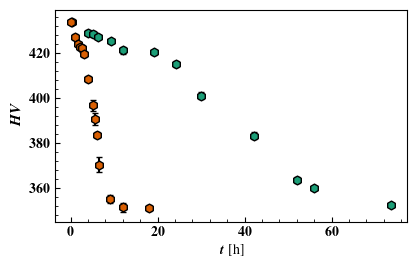

In [12]:
from matplotlib import rc
from matplotlib.ticker import AutoMinorLocator
import pandas as pd

rc('font',**{'family':'serif','serif':['Times New Roman'],'weight': 'bold'})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])

def default_axis(figsize = (6,4.5), 
               xlabel: str = None,
               ylabel: str = None,
               labelsize: int = 10,
               fontsize: int = 11,
               ax: plt.Axes = None,
               n_minor_ticks: int = 5):

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = None
    
    ax.set_xlabel(xlabel,fontsize = 10)
    ax.set_ylabel(ylabel,fontsize  = fontsize)
    ax.tick_params('both',labelsize = labelsize,direction = 'in',which = 'both')

    ax.xaxis.set_minor_locator(AutoMinorLocator(n_minor_ticks))
    ax.yaxis.set_minor_locator(AutoMinorLocator(n_minor_ticks))
    
    return fig,ax

fig,ax = default_axis(figsize = (4,2.5),
                    xlabel = r'$t$ [h]',
                    ylabel = r'$HV$')
for temp,color in zip([1150,1250],[0.1,0.2]):
    df = pd.read_csv('rf_data/alfonso_data/highly_rolled_hardness_data.csv',index_col = 0)
    df = df.loc[df['temperature'] == temp]


    ax.errorbar(df['time'],df['HV'].to_numpy(),yerr = df['std'],fmt = 'none',ecolor = 'k',capsize = 2)
    ax.scatter(df['time'],df['HV'],facecolor  = plt.get_cmap('Dark2')(color),edgecolor = 'k',
            lw = 1.0,s = 40,marker = 'h',zorder = 1000)

fig.tight_layout(pad = 0.1)
fig.savefig('images/rolled_data_example_hardness_1150C_1250C.svg')

### Extract Hardness Values

We define the material as _recrystallized_ when the hardness reache is less than $\beta$ % greater than it's minimum value, and from this first point in time onward, every recorded value is considered a recrystallized hardness ($HV_x$). 

We define the _initial_ material hardness ($HV_0$) as the first value in the time series. 

The reported data are means over a moderate number of samples ($20$). We assume that all observations are normal random variables from two populations, the initial $HV_{0}$ population and the recrystillized $HV_{x,i}$. 

By defintion, we have one observation mean for the $HV_{0}$ and an estimate of it's variance $S^2_{0}$ at each temperature. We have multiple observation means for the recystallized data, with an estimate of each samples variance $S^2_{x,i}$ for each. 

We estimate the mean of the recrystallized data as the mean of the recrystallized observations, which are normal. We estimate the total variance using a pooled estimator. Assume we have $m$ recrystallized observations with _equal samples_ in each group, and count from $i = 1...m$ 

$
S_p^2 = \frac{1}{m} \sum_{i = 1}^m  S^2_i + \frac{1}{m-1} \sum_{i = 1}^m  (\bar{x}_i - \bar{\bar{x}})^2  \\ 
 \bar{x}_i : \text{sample mean} \qquad S^2_i: \text{sample variance}
$

i.e. the pooled estimator is the mean of the variances plus the variance of the means.We assume that $\frac{(N- m) S_p^2}{\sigma_p^2} \sim \chi^2_{N - m}$ approximately, where $N = \sum_{i = 1}^m n_i$ and $n_i$ is the number of samples in each mean.

In [13]:
import warnings

def extract_hardness_data(data: pd.DataFrame,
                          thresh: float = 0.025):

    # Extract the data for the initial and recrystallized states
    # for each temperature
    temps = data['temperature'].unique()
    rx_data = []
    init_data = []
    for t in temps:
        df = data.loc[data['temperature'] == t]
        with warnings.catch_warnings(action = 'ignore'):
            df.sort_values('time',inplace = True)  
        
        scaled = (df['HV'].to_numpy() - df['HV'].min())/df['HV'].min()
        index = scaled < thresh
        i = 0
        while i < index.shape[0] and not index[i]:  
            i += 1
        
        i -=1
        
        rx_df = df.iloc[i:]
        rx_mean = rx_df['HV'].mean()
        rx_av = np.mean(rx_df['std']**2)
        rx_va = 1/(rx_df.shape[0] - 1)*np.sum((rx_df['HV'].to_numpy() - rx_mean)**2)

        rx_data.append([[rx_mean,(rx_av + rx_va)**0.5,rx_df.shape[0]]])
        init_data.append(df.iloc[0][['HV','std']].to_numpy()[np.newaxis,:])

    init_df = pd.DataFrame(np.concatenate(init_data,axis = 0),index = temps,columns = ['HV','std'])
    rx_df = pd.DataFrame(np.concatenate(rx_data),index = temps,columns = ['HV','std','num_samples'])
    return init_df,rx_df 


### Estimate Reduction in Hardness Value

=====================================
TO-DO: DOF for S_p^2
=====================================

We are specifically interested in estimating the _reduction in hardness value_, $HV_\Delta$ defined by:

$
HV_\Delta = \frac{HV_0 - HV_x}{HV_0} =  1 - R_{x0}
$

The preceeding analysis implies that $HV_0 \sim \mathcal{N}(\mu_0,\sigma_0)$ and $HV_x \sim \mathcal{N}(\mu_x,\sigma_x)$. Assuming independance of the two RV's, $R_{x0}$ is the ratio of $HV_x$ to $HV_0$ and the distribution of $R_{x0}$ is a ratio distribution of the two normal variables. This variable has an exact, analytical closed form pdf, however none of the moments are finite and we don't have the actual mean and variances of the hardnesses, only estimates, so it would be difficult to derive the distribution based on the sample statistics. Its straightforward to just sample the distributions of $HV_0$ and $HV_x$ and estimate $\mu_{\Delta}$ and confidence intervals on $HV_{\Delta}$ empircally. Student's theorem provides:

$
\frac{HX_x - \mu_{x}}{\sqrt{S^2_p/n}} \sim t_{n - 1} \\ 
\frac{HX_0 - \mu_{0}}{\sqrt{S^2_0/m}} \sim t_{m - 1} 
$

Using this information we can sample these distributions and construct a sample distribution of $H_{\Delta}$. Viewing the histogram of the samples below shows that the distribution is slightly asymmetric, and indeed the computed skeneww values confirm this. It does seem however, that a normal approximation to this distribution is adequate.

c:\Users\mlanahan3\Anaconda3\envs\py312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
sample: 100%|██████████| 105000/105000 [00:27<00:00, 3858.95it/s, 7 steps of size 6.79e-01. acc. prob=0.88]


skewness: [ 0.0034 -0.0022 -0.0153 -0.0039 -0.0164 -0.0084]


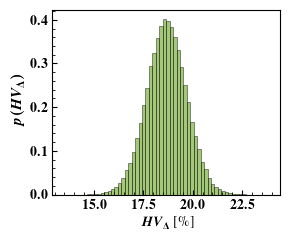

In [14]:
import numpyro 
from jax import random
from jax import numpy as jnp    
from functools import cached_property
from numpyro.diagnostics import hpdi

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

def get_ratio_samples(init_sample_mean: jnp.ndarray,
                      init_sample_std: jnp.ndarray,
                      init_n: jnp.ndarray,
                      rx_sample_mean: jnp.ndarray,
                      rx_sample_std: jnp.ndarray,
                      rx_n: jnp.ndarray):
    
    numpyro.sample('t_init',numpyro.distributions.StudentT(loc = init_sample_mean,
                                                                    scale = init_sample_std,
                                                                    df = init_n -1))
    numpyro.sample('t_rx',numpyro.distributions.StudentT(loc = rx_sample_mean,
                                                                scale = rx_sample_std,
                                                                df = rx_n ))

class InferenceSummary:

    def __init__(self,mcmc: numpyro.infer.MCMC):
    
        self.mcmc = mcmc

    @cached_property
    def samples(self):
        return self.mcmc.get_samples()
    
    @cached_property
    def hardness(self):
        return  1. - self.samples['t_rx']/self.samples['t_init']

    def print_summary(self):
        self.mcmc.print_summary()
    
    @cached_property
    def mean_hardness(self):
        return jnp.mean(self.hardness,axis = 0)
    
    @cached_property
    def std_hardness(self):
        return jnp.std(self.hardness,axis = 0,ddof = 1)
    
    def confidence_interval(self,alpha: float = 0.05):
        return hpdi(self.hardness, 1.- alpha)

def run_inference(init_data: pd.DataFrame,
                  rx_data: pd.DataFrame,
                  rng_key: jnp.ndarray,
                  num_data_samples: int = 20,
                  num_samples: int = 3000,
                  num_warmup: int = 500,
                  num_chains: int = 1):
    
    
    nuts_kernel = numpyro.infer.NUTS(get_ratio_samples)
    mcmc = numpyro.infer.MCMC(
        nuts_kernel,
        num_samples=num_samples,
        num_warmup=num_warmup,
        num_chains= num_chains,
    )

    values = (init_data['HV'].to_numpy(),
            init_data['std'].to_numpy(),
            num_data_samples - 1,
            rx_data['HV'].to_numpy(),
            rx_data['std'].to_numpy(),
            rx_data['num_samples'].to_numpy()*(num_data_samples - 1))    

    mcmc.run(rng_key,*(jnp.array(v) for v in values))
    return InferenceSummary(mcmc)


data = pd.read_csv('rf_data/alfonso_data/highly_rolled_hardness_data.csv',index_col = 0)
init_data,rx_data = extract_hardness_data(data,thresh = 0.01)

inference = run_inference(init_data,rx_data,rng_key_,num_samples = 100000,num_warmup = 5000,num_chains = 1)

fig,ax = default_axis(figsize = (3,2.5),
                      xlabel = r'$HV_{\Delta}$ [\%]',
                     ylabel = r'$p(HV_{\Delta})$')
ax.hist(inference.hardness[:,4]*100,bins = 60,density = True,edgecolor = 'k',
        facecolor = plt.get_cmap('Dark2')(0.6),alpha = 0.6,lw = 0.5)
fig.tight_layout()


skewness = jnp.mean(((inference.hardness - inference.mean_hardness)/inference.std_hardness)**3,axis = 0)
print(f'skewness: {round(skewness,4)}')


### Visualization 

The below scatter shows computed mean $HV_\Delta$ at each temperature, with 95% confidence intervals for each data point for W material processed in two different ways. The common mean and 95% confidence intervals are shown as horizontal lines. It appears visually that assuming the reduction in hardness is indepednant of temperature may be a good assumption.

sample: 100%|██████████| 105000/105000 [00:26<00:00, 3891.03it/s, 7 steps of size 6.15e-01. acc. prob=0.91]


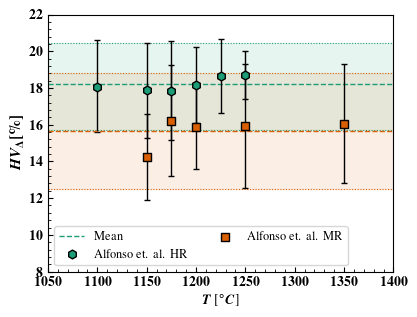

In [15]:

fig,ax = default_axis(figsize = (4,3),
                    xlabel = r'$T$ [$^\circ C$]',
                    ylabel = r'$HV_\Delta [\%]$')

files = ['rf_data/alfonso_data/highly_rolled_hardness_data.csv',
         'rf_data/alfonso_data/moderate_roll_hardness_data.csv']

labels = ['Alfonso et. al. HR',
          'Alfonso et. al. MR']

sampled_inferences = []
i = 0
for file,marker,color,label in zip(files,['h','s','o'],[0.1,0.2,0.7],labels):
    data = pd.read_csv(file,index_col = 0)
    init_data,rx_data = extract_hardness_data(data,thresh = 0.01)
    
    if i >= 2:
        hv_d = (init_data['HV'] - rx_data['HV'])/init_data['HV']


        ax.scatter(hv_d.index,hv_d*100,facecolor = plt.get_cmap('Dark2')(color),
                edgecolor = 'k',s = 40,marker = marker,lw = 0.75,
                label = label,zorder = 2000)
    else:
        
        inference = run_inference(init_data,rx_data,rng_key_,num_samples = 100000,num_warmup = 5000,num_chains = 1)
        sampled_inferences.append(inference)
        yerr = np.abs(inference.mean_hardness[np.newaxis,:] - inference.confidence_interval(0.05))

        common_mean = inference.mean_hardness.mean()
        common_ci = hpdi(inference.hardness.flatten(),0.95)

        ax.axhline(common_mean*100,color = plt.get_cmap('Dark2')(color),ls = '--',lw = 1.0,
                   label = f'Mean' if i == 0 else None)
        ax.axhline(common_ci[0]*100,color = plt.get_cmap('Dark2')(color),ls = ':',lw = 0.75)
        ax.axhline(common_ci[1]*100,color = plt.get_cmap('Dark2')(color),ls = ':',lw = 0.75)
        ax.fill_between(np.linspace(1050,1500),common_ci[0]*100,common_ci[1]*100,
                        color = plt.get_cmap('Dark2')(color),alpha = 0.1)
        
        ax.errorbar(init_data.index,inference.mean_hardness*100,yerr = yerr*100,
                    fmt = 'none',ecolor = 'k',capsize = 2,lw = 1.0)
        ax.scatter(init_data.index,inference.mean_hardness*100,facecolor = plt.get_cmap('Dark2')(color),
                edgecolor = 'k',s = 40,marker = marker,lw = 1.0,
                label = label,zorder = 2000)
    i+=1


ax.legend(fontsize = 9,ncols = 2)
ax.set_ylim(8,22)
ax.set_xlim(1050,1400)
fig.tight_layout(pad = 0.1)
fig.savefig('images/hardness_reduction.svg')

### Testing Independance of Temperature

*NOTE: a similar result could also be obtained via linear regression and applying the nullity of coefficient test.

We suppose that: 

$
HV_{\Delta,ij} = \theta_i + \varepsilon_{i} \\ 
i = 1,...,6 \qquad \text{counts temperature} \\ 
j = 1,...,m \qquad \text{counts number of samples}
$

And we'd like to test: 

$
\mathcal{H}_0: \theta_i = \bar{\theta} \ \ \forall i \qquad \text{vs.} \qquad \mathcal{H}_1: \exist i \ \text{s.t.} \theta_i \neq \ \bar{\theta} 
$

This is the null hypothesis under one-way ANOVA, however our approach is complicated by violation of the classical normality assumptions regarding the error term, $\varepsilon_{i}$. The assumptions of independant errors with $\mathbb{E}[\varepsilon_{i}] = 0$, still make sense, however we do not assume they have a common distribution. Under $\mathcal{H}_0$ we have that 

$
\theta_i - \bar{\theta} = \varepsilon_i \sim p_i \\ 
p(\varepsilon_1,\varepsilon_2,...,\varepsilon_6) = \prod_{i = 1}^6 p_i \\ 
$

Where $p_{i}$ is represented through samples. To test $\mathcal{H}_0$ at level $\alpha$ we estimate $\varepsilon_i$ using $\tilde{\varepsilon}_i$ using estimates for $\theta_i$ and $\bar{\theta}$ to confirm they each lie within $[p_{i,\gamma/2},p_{i,1 - \gamma/2}]$ where $1- \gamma = (1 - \alpha)^{1/n} \implies \gamma = 1 - (1 - \alpha)^{1/n}$

This test confirms, for both data sets, what we suspected based on the plot in the previous section: the change in hardness is independant of temperature

In [16]:
alpha = 0.05


inf_names = ['Medium Rolled','Highly Rolled']

for inf,name in zip(sampled_inferences,inf_names):
    print(name)
    print('-----------------------------------\n')
    means = inf.mean_hardness
    common_mean = means.mean()
    diff = np.array(means -common_mean)

    # compute the confidence interval on the difference in means, effectively the quantiles on the error distribution.
    gamma = 1 - (1-alpha)**(1/means.shape[0])
    ci = inf.confidence_interval(gamma) - means
    print('Difference in Mean | Lower Bound | Upper Bound')
    for i in range(diff.shape[0]):
        print(f'{round(diff[i]*100,3)} {np.round(ci[0,i]*100,1)} {np.round(ci[1,i]*100,1)}')

    print('\n-----------------------------------\n\n')



Medium Rolled
-----------------------------------

Difference in Mean | Lower Bound | Upper Bound
-0.173 -3.5 3.4000000953674316
-0.339 -3.5 3.5
-0.359 -3.700000047683716 3.700000047683716
-0.068 -2.799999952316284 2.799999952316284
0.441 -2.700000047683716 2.700000047683716
0.498 -1.8000000715255737 1.7000000476837158

-----------------------------------


Highly Rolled
-----------------------------------

Difference in Mean | Lower Bound | Upper Bound
-1.402 -3.1000001430511475 3.1000001430511475
0.543 -4.0 4.0
0.206 -3.1000001430511475 2.9000000953674316
0.287 -4.599999904632568 4.300000190734863
0.365 -4.300000190734863 4.300000190734863

-----------------------------------




### Testing Common Mean Between Processed Materials

We suppose that: 

$
HV_{\Delta,ijk} = \theta_{ik} + \varepsilon_{ik} \\ 
i = 1,...,6 \qquad \text{counts temperature} \\ 
j = 1,...,m \qquad \text{counts number of samples} \\ 
k = 1,2 \qquad \text{denotes the material processed with method} \   k
$

And we'd like to test: 

$
\mathcal{H}_0: \theta_{ik} = \bar{\theta} \ \ \forall i \qquad \text{vs.} \qquad \mathcal{H}_1: \exist i \ \text{or} \ k \ \text{s.t.} \theta_{ik} \neq \ \bar{\theta} 
$

And it appears we cannot reject $\mathcal{H}_0$ unless we accept rejection with $\alpha \approx 0.2$. 

In [17]:
alpha = 0.2
gamma = 1 - (1-alpha)**(1/sum([inf.mean_hardness.shape[0] for inf in sampled_inferences]))
means = jnp.concat([inf.mean_hardness for inf in sampled_inferences],axis = 0)
ci = jnp.concat([inf.confidence_interval(gamma) for inf in sampled_inferences],axis = 1)- means
common_mean = means.mean()
diff = means - common_mean
print('Difference in Mean | Lower Bound | Upper Bound')
for i in range(diff.shape[0]):
    print(f'{round(diff[i]*100,3)} {np.round(ci[0,i]*100,1)} {np.round(ci[1,i]*100,1)}')

print('\n-----------------------------------\n\n')


Difference in Mean | Lower Bound | Upper Bound
0.9900000691413879 -3.0 3.0
0.8240000605583191 -3.1000001430511475 3.1000001430511475
0.8030000329017639 -3.200000047683716 3.200000047683716
1.0940001010894775 -2.4000000953674316 2.5
1.6040000915527344 -2.4000000953674316 2.4000000953674316
1.6600000858306885 -1.600000023841858 1.5
-2.7960002422332764 -2.799999952316284 2.700000047683716
-0.8520000576972961 -3.6000001430511475 3.6000001430511475
-1.1890000104904175 -2.700000047683716 2.700000047683716
-1.1080000400543213 -4.0 4.0
-1.03000009059906 -3.9000000953674316 3.9000000953674316

-----------------------------------




### Extrapolating $HV_\Delta$ to Different W Alloys

We'd like to assess if we can use these results for pure W to extrapolate to different alloys. Tschudia et al. provide data for several tungsten alloys annealed at different temperatures for 1 hour, plotted below. The data further confirms our hypothesis that $HV_\Delta$ is independant of temperature. We can see that when the temperature is sufficiently high enough for the material to recrystallize in one hour, the hardness reaches a relatively constant value.

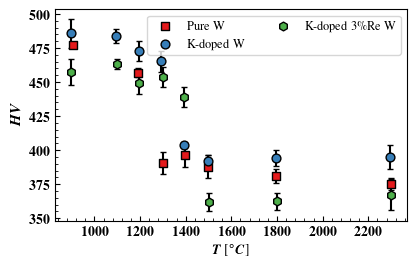

In [18]:
fig,ax = default_axis(figsize = (4,2.5),
                    xlabel = r'$T$ [$^\circ C$]',
                    ylabel = r'$HV$')

alloys = ['Pure W data','K-doped W data','K-doped 3%Re W data']
labels = ['Pure W','K-doped W',r'K-doped 3\%Re W']
for alloy,label,color,marker in zip(alloys,labels,[0.1,0.2,0.3],['s','o','h']):
    df = pd.read_csv(f'rf_data/tschudia_data/tschudia_data_{alloy}.csv')

    ax.errorbar(df['temperature'],df['hardness'].to_numpy(),yerr = df['hardness error'],fmt = 'none',ecolor = 'k',capsize = 2)
    ax.scatter(df['temperature'],df['hardness'],facecolor  = plt.get_cmap('Set1')(color),edgecolor = 'k',
            lw = 1.0,s = 40,marker = marker,zorder = 1000,label = label)

ax.legend(fontsize = 9,ncol = 2)
fig.tight_layout(pad = 0.1)

We'll use the first value in each temperature series as $HV_0$ and the last three values as realizations of $HV_x$, leveraging temperature independance, to estimate $HV_\Delta$ for each alloy. Measurements and reported standard deviations are estimated using the average of 5 points. We use the pooled estimator for the standard deviation of recrystallized hardness again.  

In [39]:
alloys = ['Pure W data','K-doped W data','K-doped 3%Re W data']
infered_alloys = dict.fromkeys(alloys)
for alloy in alloys:
    df = pd.read_csv(f'rf_data/tschudia_data/tschudia_data_{alloy}.csv')
    df.sort_values('temperature',inplace = True)
    init_data = df.iloc[0:1][['hardness','hardness error']]
    init_data.columns = ['HV','std']

    rx_data = df.iloc[-3:][['hardness','hardness error']]
    rx_mean = rx_data['hardness'].mean()
    rx_std = (np.mean(rx_data['hardness error']**2) + rx_data['hardness'].var(ddof = 1))**0.5
    rx_data = pd.DataFrame([[rx_mean,rx_std,15]],columns = ['HV','std','num_samples'])
    infered_alloys[alloy] = run_inference(init_data,rx_data,rng_key_,num_data_samples = 5,
                                          num_samples = 100000,num_warmup = 5000,num_chains = 1)



sample: 100%|██████████| 105000/105000 [00:21<00:00, 4823.91it/s, 3 steps of size 8.23e-01. acc. prob=0.89]


### Displaying the Data
Plotting the data on a scatter below, we can see that the mean reduction in hardness values all fall within a pretty consisten range, with the alloy of interest K-doped 3%Re W alloy, having the largest value. Also plotted is the common mean as a black dotted line, and 95% confidence intervals for all the data. 

The spread in the data for our alloy of interest is pretty large, and we'd like a reference value for reduction in hardness we can use as a reference across _all_ tungsten's, for multiple processing methods and alloys. It's a good idea to be conservative as well, so we'll use the 95% confidence interval upper bound across all tungsten alloys as our estimate. 

$HV_\Delta = 22.3\%$ isn't all the different from the mean for the specific tungsten alloy of $20.4\%$ or the upper bound for the original W data of $20.5\%$, and the small differences between these numbers won't make much impact on subsequent simulations. The number $HV_\Delta = 22.3\%$ has the benefit of being a conservative estimate for the reduction in hardness of the material due to recrystalliation if we don't know anything about a W material, _viz._ we are $95\%$ confident that the hardness reduction due to recrystillization for some unknown W or W alloy is less than $22.3\%$

                        Mean %  Lower Bound %  Upper Bound %
Alfonso et. al. HR   18.219614      15.709215      20.455568
Alfonso et. al. MR   15.662150      12.473726      18.837326
Pure W data          20.100399      15.847367      24.180305
K-doped W data       18.876886      13.438183      24.199968
K-doped 3%Re W data  20.383394      14.300900      26.336771

Common Mean: 17.6 Lower Bound 12.800000190734863 Upper Bound 22.299999237060547


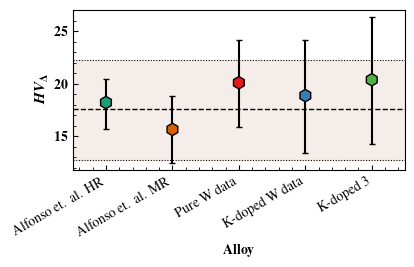

In [49]:
alpha = 0.05


index = []
data = []
all_samples = []
#Get Pure W Results
for label,inference in zip(labels,sampled_inferences):
    all_samples.append(inference.hardness.flatten())
    mean_hardness_reduction = inference.mean_hardness.mean()
    ci = hpdi(inference.hardness.flatten(),1-alpha)
    data.append([mean_hardness_reduction,ci[0],ci[1]])
    index.append(label)

#Get Tschudia Results
for alloy in alloys:
    all_samples.append(infered_alloys[alloy].hardness.flatten())
    mean_hardness_reduction = infered_alloys[alloy].mean_hardness[0]
    ci = infered_alloys[alloy].confidence_interval(alpha).squeeze()
    data.append([mean_hardness_reduction,ci[0],ci[1]])
    index.append(alloy)

hr_df = pd.DataFrame(np.array(data)*100,index = index,columns = ['Mean %','Lower Bound %','Upper Bound %'])
print(hr_df)
print('')

common_mean = np.concatenate(all_samples).mean()*100    
common_ci = hpdi(np.concatenate(all_samples),1-alpha)*100

print(f'Common Mean: {round(common_mean,1)} Lower Bound {round(common_ci[0],1)} Upper Bound {round(common_ci[1],1)}')
fig,ax = default_axis(figsize = (4,2.5),
                    xlabel = r'\textbf{Alloy}',
                    ylabel = r'$HV_\Delta$')

colors = np.concatenate([plt.get_cmap('Dark2')([0.1,0.2]),plt.get_cmap('Set1')([0.1,0.2,0.3])]) 
yerr = np.abs(hr_df[['Lower Bound %','Upper Bound %']].to_numpy().T - hr_df['Mean %'].to_numpy())
ax.errorbar(np.arange(5),hr_df['Mean %'].to_numpy(),yerr = yerr,
            fmt = 'none',ecolor = 'k',capsize = 2)
ax.scatter(np.arange(5),hr_df['Mean %'].to_numpy(),facecolor  = colors,edgecolor = 'k',
        lw = 1.0,s = 80,marker = 'h',zorder = 1000)
ax.axhline(common_mean,color = 'k',ls = '--',lw = 1.0)
ax.axhline(common_ci[0],color = 'k',ls = ':',lw = 0.75)
ax.axhline(common_ci[1],color = 'k',ls = ':',lw = 0.75)
ax.fill_between(np.linspace(-1,5),common_ci[0],common_ci[1],
                color = plt.get_cmap('Set1')(0.7),alpha = 0.1)

ax.set_xlim([-0.5,4.5])
ax.set_xticks(np.arange(len(hr_df.index)))
ax.set_xticklabels(hr_df.index, rotation=30, ha='right', fontsize=10)
fig.tight_layout(pad = 0.1)